In [1]:
%load_ext autoreload

In [2]:
import math
import numpy as np

import torch
from torch import nn
from torch import distributions

import torchvision
from torchvision.transforms import v2

import numpy as np
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tqdm.auto import trange

In [75]:
%autoreload 2
from model import SimpleNet, ModelOutput, Energy, MNISTEnergy, MNISTSampler
from samplers import losses
from buffers import ReplayBuffer
from datasets_2d import DatasetSampler, GaussMix
from data.infinite_loader import InfiniteDataLoader
from ema import EMA

from samplers.utils import sample_trajectory

In [69]:
def scatter(tensor, alpha=1.0, label=None, title=None, axis_off=True):
    plt.figure(figsize=(5, 5))
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha, label=label)
    if title is not None:
        plt.title(title)
    if axis_off:
        plt.axis('off')

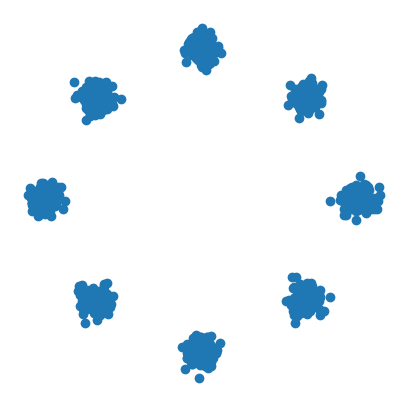

In [78]:
means = torch.tensor([
        [-2, 2], [2, 2], [-3, 0], [3, 0],
        [0, -3], [0, 3], [-2, -2], [2, -2]
    ]).float() * 0.99
sigmas = torch.ones_like(means) * 0.15
gm = GaussMix(means, sigmas)
scatter(gm.sample(1000))

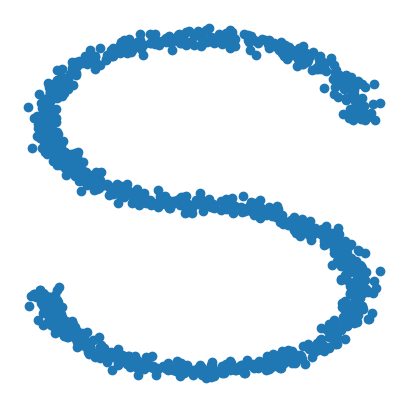

In [ ]:


sampler = DatasetSampler(
    p_0='s_curve', p_0_args=[None, 0.05, 3],
    p_1='two_circles', p_1_args=[None, 0.02, 3],
)

x_0, x_1 = sampler.sample(128 * 9)

scatter(x_0)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T


def scatter(tensor, alpha=1.0, label=None):
    plt.scatter(tensor[:, 0], tensor[:, 1], alpha=alpha, label=label)


def plot_trajectory(trajectory, labels: list[str] | None = None, 
                    indices: None | list = None, title: str | None = None, 
                    xlim=(-1.5, 1.5), ylim=(-1.5, 1.5)):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        if labels is not None:
            labels = [labels[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    if title is not None:
        figure.suptitle(title)
    
    for i, sample in enumerate(trajectory):
        title = labels[i] if labels is not None else f'iter {i}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1]) 
        axes[i].set_xlim(*xlim)
        axes[i].set_ylim(*ylim)
    
    return figure

@torch.no_grad()
def draw_level_lines(func, samples=None, lims=(-2, 2), nsamples: int = 100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).numpy()  # Shape: [100, 100]
    Z = Z.reshape(nsamples, nsamples).T

    plt.figure()
    contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
    plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)    
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.colorbar(label='Function Value')                  # Add color bar
    plt.title('Level Lines of the Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()


def get_drid(lims=(-5, 5), nsamples=100):
    x = np.linspace(*lims, nsamples)  # Define x-axis range
    y = np.linspace(*lims, nsamples)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)
    return torch.from_numpy(grid_points).reshape(-1, 2).float()

In [6]:
alpha = 4.0
gamma = 0.012
t_max = 0.024
n_steps = 20


def ref_process(x, t):
    return ModelOutput(drift=alpha * x)


def get_mean_log_var(model, x, t, dt):
    log_var = torch.as_tensor(2.0 * dt, device=x.device).log()
    output = model(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var
    
    mean = x + output.drift * dt
    return mean, log_var


def make_euler_maruyama_step(model, x, t, dt):
    mean, log_var = get_mean_log_var(model, x, t, dt)
    return mean + torch.randn_like(mean) * log_var.exp().sqrt()


def log_normal_density(x, mean, log_var):
    return - 0.5 * (log_var + torch.exp(- log_var) * (x - mean).pow(2)).sum(-1)


# def sample_trajectory(model, x_start, direction, dt, n_steps, t_max, 
#                       only_last: bool = False, return_timesteps: bool = False):
#     assert direction in {"forward", "backward"}
#     trajectory, timesteps = [x_start], [f"{t_max if direction == 'backward' else 0}"]
    
#     for t_step in (
#             torch.linspace(dt, t_max, n_steps).flip(-1) \
#             if direction == 'backward' \
#             else torch.linspace(0, t_max - dt, n_steps)
#         ):
#         shift = - dt if direction == "backward" else + dt
#         timesteps.append(f"{t_step.item() + shift:.3f}")
        
#         t = torch.ones(x_start.size(0)) * t_step
#         trajectory.append(make_euler_maruyama_step(model, trajectory[-1], t, dt))
    
#     if return_timesteps:
#         return trajectory, timesteps
    
#     if only_last:
#         return trajectory[-1]
    
#     return trajectory


def check_grad_is_nan(model, name):
    for n, p in model.named_parameters():
        if torch.isnan(p.grad).any():
            print(f"NaN in {n} grad of {name}")
            return True
    return False


class FixedSizeDataset:
    def __init__(self, dataset):
        self.dataset = dataset
        self.size = dataset.size(0)

    def sample(self, batch_size):
        idxs = torch.randint(0, self.size, (batch_size,))
        return self.dataset[idxs]

In [ ]:
@torch.no_grad()
def plot_training_summary(energy, fwd_model, sampler, fwd_losses, 
                          bwd_losses, energy_losses, gamma, 
                          n_steps, t_max, noise_std, n_samples=512):
    fig = plt.figure(figsize=(16, 16))
    
    # Create grid spec for custom layout
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 0.7, 0.7])
    
    # Plot 1: Samples x_0 and x_1
    ax1 = fig.add_subplot(gs[0, 0])
    with torch.no_grad():
        x_0, _ = sampler.sample(n_samples)
        x_0n = x_0 + torch.randn_like(x_0) * noise_std
        x_1 = sample_trajectory(fwd_model, x_0n, "forward", gamma, n_steps, t_max, only_last=True)
    
    ax1.scatter(x_0[:, 0], x_0[:, 1], alpha=0.5, label='x_0', color='blue')
    ax1.scatter(x_1[:, 0], x_1[:, 1], alpha=0.5, label='x_1', color='red')
    ax1.legend()
    ax1.set_title('Samples x_0 and x_1')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    
    # Plot 2: Energy function
    ax2 = fig.add_subplot(gs[0, 1])
    limits = (-5, 5)
    x = np.linspace(*limits, 200)
    y = np.linspace(*limits, 200)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X, Y], axis=-1)
    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    
    with torch.no_grad():
        log_density = -energy(grid_points).detach()
        log_density = log_density - log_density.max()
    Z = log_density.numpy().reshape(200, 200)
    
    contour = ax2.contour(X, Y, Z, levels=7, colors='k')
    ax2.clabel(contour, inline=True, fontsize=6)
    im = ax2.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)
    ax2.set_title('- E(x)')
    fig.colorbar(im, ax=ax2, label='Energy Value')
    ax2.set_xlim(*limits)
    ax2.set_ylim(*limits)
    
    # Plot 3: Forward losses
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(fwd_losses)
    ax3.set_title('Forward Losses')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Loss')
    ax3.grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        ax3.set_yscale('symlog')
        ax3.set_ylabel('Loss (symlog scale)')
    
    # Plot 4: Backward losses
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(bwd_losses)
    ax4.set_title('Backward Losses')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('Loss')
    ax4.grid(True)
    if min(bwd_losses) < -10:
        ax4.set_yscale('symlog')
        ax4.set_ylabel('Loss (symlog scale)')
    
    # Plot 5: Energy losses
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(energy_losses)
    ax5.set_title('Energy Losses')
    ax5.set_xlabel('Iterations')
    ax5.set_ylabel('Loss')
    ax5.grid(True)
    if min(energy_losses) < -10:
        ax5.set_yscale('symlog')
        ax5.set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def plot_losses(fwd_losses, bwd_losses, energy_losses):
    """
    Plot the three loss curves in a single row.
    
    Args:
        fwd_losses: List of forward process losses
        bwd_losses: List of backward process losses
        energy_losses: List of energy function losses
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot forward losses
    axes[0].plot(fwd_losses)
    axes[0].set_title('Forward Losses')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    if min(fwd_losses) < -10 or max(fwd_losses) > 100:
        axes[0].set_yscale('symlog')
        axes[0].set_ylabel('Loss (symlog scale)')
    
    # Plot backward losses
    axes[1].plot(bwd_losses)
    axes[1].set_title('Backward Losses')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    if min(bwd_losses) < -10:
        axes[1].set_yscale('symlog')
        axes[1].set_ylabel('Loss (symlog scale)')
    
    # Plot energy losses
    axes[2].plot(energy_losses)
    axes[2].set_title('Energy Losses')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    if min(energy_losses) < -10:
        axes[2].set_yscale('symlog')
        axes[2].set_ylabel('Loss (symlog scale)')
    
    plt.tight_layout()
    plt.show()


def plot_image_trajectory(images: list[torch.Tensor], 
                          timesteps: list[str]=None, 
                          title='', 
                          apply_rescale=True):
    n_images = len(images)
    h = images[0].size(2)

    images = torch.stack(images, dim=0).permute(1, 0, 2, 3, 4)
    images = images.reshape(-1, 1, h, h)
    
    if apply_rescale:
        images = (images + 1) / 2
    images = torch.clip(images, 0.0, 1.0)

    image_grid = torchvision.utils.make_grid(images, nrow=n_images, 
                                             padding=1, pad_value=1)
    
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.imshow(image_grid.permute(1, 2, 0))
    if timesteps is not None:
        tick_positions = np.arange(n_images) * (h + 1) + 1 + h // 2
        plt.xticks(tick_positions, timesteps, rotation=0)
        plt.xlabel("Image Index")
    else:
        plt.xticks([])
    plt.yticks([])
    plt.show()

## SB+EBM training

In [311]:
mnist_transform = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Resize((8, 8)),
    v2.Lambda(lambda x: 2*x - 1)
])
mnist_dataset = torchvision.datasets.MNIST('./mnist/data', train=True, download=True, 
                                           transform=mnist_transform)

sampler = InfiniteDataLoader(mnist_dataset, batch_size=16, shuffle=True)

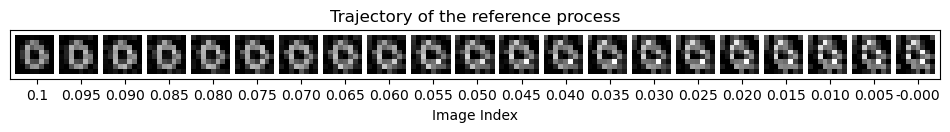

In [ ]:
alpha = 0.24
dt = 0.005
t_max = 0.1
n_steps = 20

assert dt * n_steps == t_max

x_0 = sampler.sample(1)
trajectory, timesteps = sample_trajectory(ref_process, x_0, 'backward', dt, 
                                          n_steps, t_max, return_timesteps=True)
plot_image_trajectory(trajectory, timesteps, "Trajectory of the reference process")


In [308]:
energy = MNISTEnergy()
fwd_model = MNISTSampler(1, 1, 16, 16)
bwd_model = MNISTSampler(1, 1, 16, 16)

energy_ema = EMA(energy, decay=0.999)
energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=2e-4)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=1e-3)

num_bwd_iters = 1
num_fwd_iters = 5
num_energy_iters = 1
milestones = [3000, 8000]
fwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    fwd_optim, 
    milestones=[ms * num_fwd_iters for ms in milestones], 
    gamma=0.4
)
bwd_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bwd_optim, 
    milestones=[ms * num_bwd_iters for ms in milestones], 
    gamma=0.4
)
energy_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    energy_optim, 
    milestones=[ms * num_energy_iters for ms in milestones], 
    gamma=0.4
)

p1_buffer = ReplayBuffer(2048, update_fraction=1.0)
fwd_losses, bwd_losses, energy_losses = [], [], []
current_iter = 0

Iter=4420, backward Loss: -2288.672119140625,  backward lr 0.0004


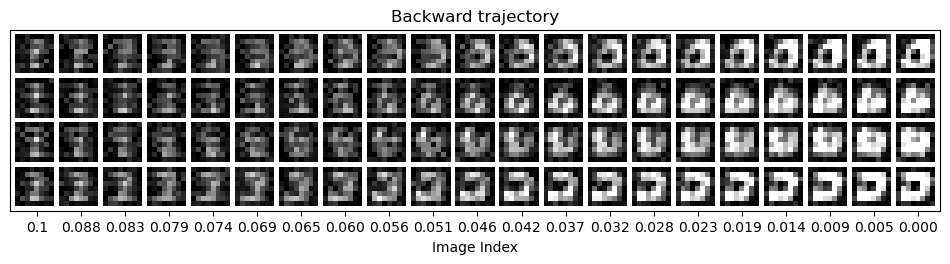

Iter=4420, Forward Loss: 181.69000244140625,  forward lr 8e-05


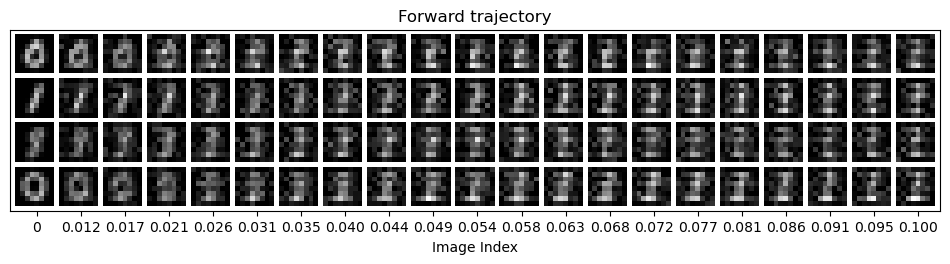

Iter=4420, Energy Loss: -48.469566345214844,  energy lr 8e-05


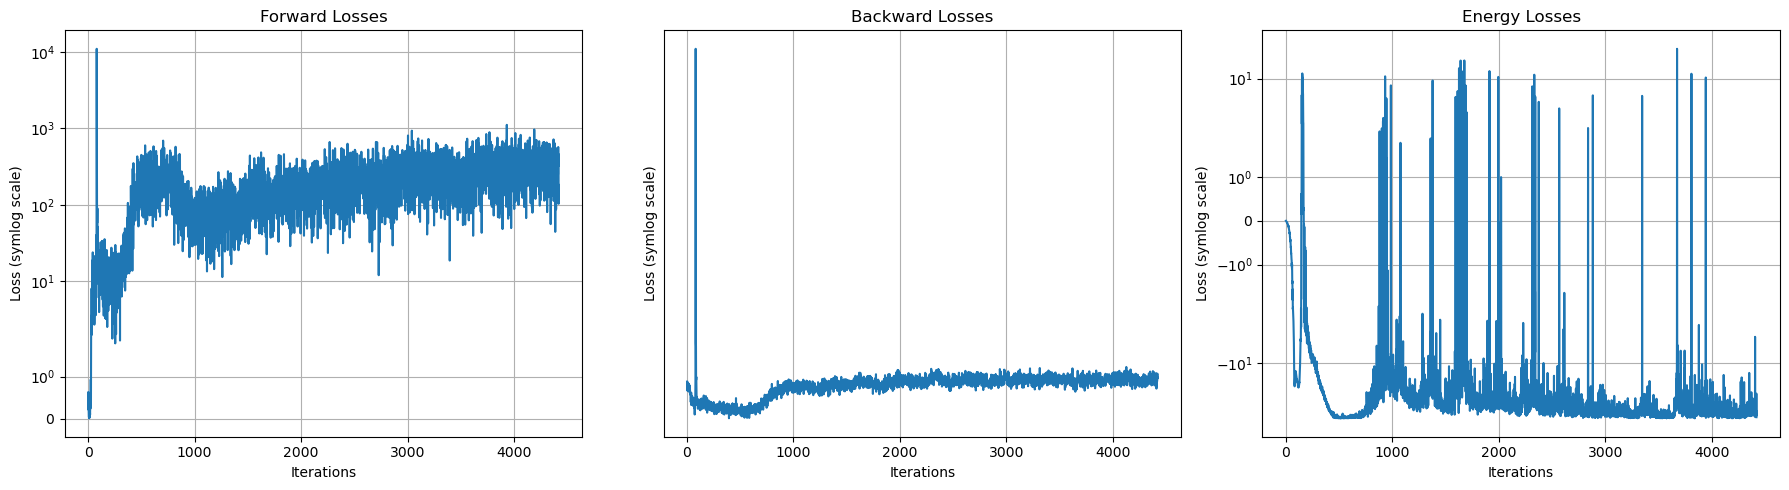

KeyboardInterrupt: 

In [316]:
seed_everything(3704)
N_TRAJECTORIES = 2
N_SB_STEPS = 10_000
BATCH_SIZE = 16

logging_frequency = 20
noise_std = 0.0
use_buffer = False
resample_x_0 = True


for it in range(current_iter, N_SB_STEPS):
    current_iter = it

    if it >= 5500:
        energy_optim.param_groups[0]['lr'] = 4e-5
        fwd_optim.param_groups[0]['lr'] = 4e-5
        bwd_optim.param_groups[0]['lr'] = 1e-4
    
    x_train = sampler.sample(BATCH_SIZE)

    # TRAIN BACKWARD PROCESS
    for _ in range(num_bwd_iters):
        bwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = sampler.sample(BATCH_SIZE)
        x_0 = x_train + torch.randn_like(x_train) * noise_std

        _fwd_model = ref_process if it == 0 else fwd_model
        loss = losses.compute_bwd_tlm_loss(
            _fwd_model, bwd_model, x_0, dt, t_max, n_steps
        )
       
        assert not torch.isnan(loss).any(), "backward loss is NaN"
        check_grad_is_nan(bwd_model, "bwd_model")
        
        bwd_optim.step()
        bwd_scheduler.step()
        
    bwd_losses.append(loss.item())

    # LOG BACKWARD TRAJECTORY
    if it % logging_frequency == 0:
        clear_output(wait=True)
        print(
            f'Iter={it}, backward Loss: {loss.item()},', 
            f" backward lr {bwd_optim.param_groups[0]['lr']}"
        )
        with torch.no_grad():
            x_0 = sampler.sample(4)
            # x_0 = x_0 + torch.randn_like(x_0) * noise_std
            
            _fwd_model = ref_process if it == 0 else fwd_model
            fwd_trajectory, timesteps = sample_trajectory(
                _fwd_model, x_0, "forward", gamma, 
                n_steps, t_max, return_timesteps=True
            )
            bwd_trajectory, timesteps = sample_trajectory(
                bwd_model, fwd_trajectory[-1], "backward", 
                gamma, n_steps, t_max, return_timesteps=True
            )
        
        plot_image_grajectory(bwd_trajectory, timesteps, "Backward trajectory")

    # TRAIN FORWARD PROCESS
    for _ in range(num_fwd_iters):
        fwd_optim.zero_grad(set_to_none=True)

        if resample_x_0:
            x_train = sampler.sample(BATCH_SIZE)

        x_0 = x_train[:BATCH_SIZE // N_TRAJECTORIES].repeat(N_TRAJECTORIES, 1, 1, 1)
        x_0 = x_0 + torch.randn_like(x_0) * noise_std
        
        loss = losses.compute_fwd_vargrad_loss(
            fwd_model, bwd_model, lambda x: - energy(x),
            x_0, dt, t_max, n_steps, 
            p1_buffer=p1_buffer,
            n_trajectories=N_TRAJECTORIES,
            clip_range=(-10000, 10000)
        )
        
        assert not torch.isnan(loss).any(), "forward loss is NaN"
        loss.backward()
        check_grad_is_nan(fwd_model, "fwd_model")
        
        fwd_optim.step()
        fwd_scheduler.step()

    fwd_losses.append(loss.item())

    # LOG FORWARD TRAJECTORY
    if it % logging_frequency == 0:
        print(
            f'Iter={it}, Forward Loss: {loss.item()},', 
            f" forward lr {fwd_optim.param_groups[0]['lr']}"
        )
        with torch.no_grad():
            x_0 = sampler.sample(4)
            # x_0 = x_0 + torch.randn_like(x_0) * noise_std
            fwd_trajectory, timesteps = sample_trajectory(
                fwd_model, x_0, "forward", gamma, 
                n_steps, t_max, return_timesteps=True
            )
        
        plot_image_grajectory(fwd_trajectory, timesteps, "Forward trajectory")

    # TRAIN ENERGY FUNCTION
    for _ in range(num_energy_iters):
        if resample_x_0:
            x_train = sampler.sample(BATCH_SIZE)

        if use_buffer:
            x_1 = p1_buffer.sample(BATCH_SIZE)
        else:
            x_train_noisy = x_train + torch.randn_like(x_train) * noise_std
            x_1 = sample_trajectory(fwd_model, x_train_noisy, "forward", dt, 
                                    n_steps, t_max, only_last=True)

        energy_optim.zero_grad(set_to_none=True)
        loss = losses.ebm_loss(energy, x_train, x_1, alpha=0.01, reg_type='l2')

        assert not torch.isnan(loss).any(), "energy loss is NaN"
        loss.backward()
        check_grad_is_nan(energy, "energy")

        energy_optim.step()
        # energy_ema.update()
        energy_scheduler.step()
    
    energy_losses.append(loss.item())

    # LOG ENERGY FUNCTION
    limits = (-5, 5)
    if it % logging_frequency == 0:
        # energy_ema.apply_shadow()
        print(
            f'Iter={it}, Energy Loss: {loss.item()},', 
            f" energy lr {energy_optim.param_groups[0]['lr']}"
        )
        plot_losses(fwd_losses, bwd_losses, energy_losses)
        # energy_ema.restore()

In [ ]:
step_size = 0.01
x = torch.randn(16, 1, 8, 8)
# x_true = sampler.sample(16)


for i in range(3001):
    if i % 250 == 0:
        grid = torchvision.utils.make_grid(x, nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
    

    
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    x = x - 0.5 * step_size * grad + torch.randn_like(x) * math.sqrt(step_size)

## Ebm training

In [17]:
mnist_transform = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    v2.Resize((8, 8)),
    v2.Lambda(lambda x: 2*x - 1)
])
mnist_dataset = torchvision.datasets.MNIST('./mnist/data', train=True, download=True, 
                                           transform=mnist_transform)

sampler = InfiniteDataLoader(mnist_dataset, batch_size=16, shuffle=True)

Iteration 1, energy loss: 0.01253828126937151, energy lr 5.99899999999945e-07


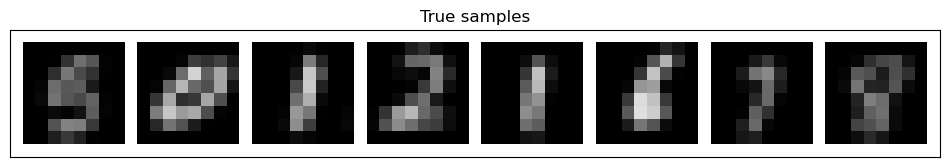

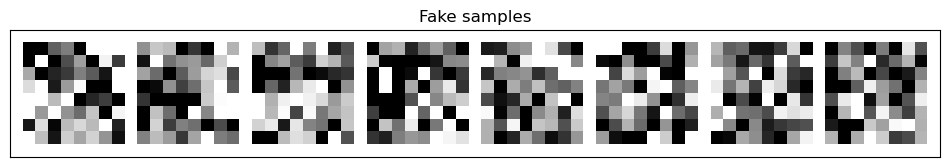

Iteration 1000, energy loss: 36.717041015625, energy lr 0.0004999999999999999


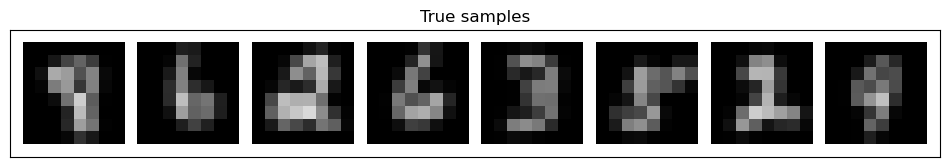

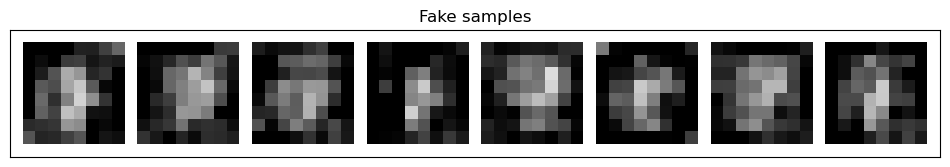

Iteration 2000, energy loss: 172.0972900390625, energy lr 0.00037502500000000013


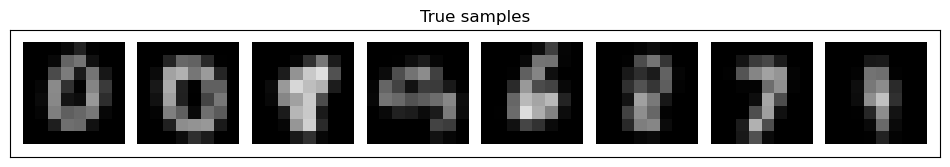

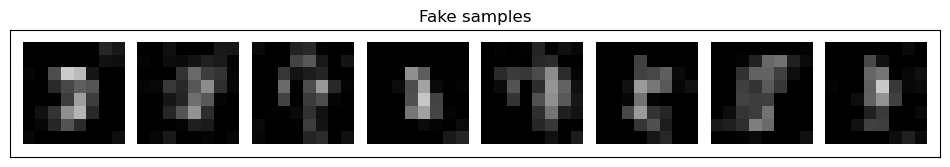

Iteration 3000, energy loss: -220.30224609375, energy lr 0.00025005


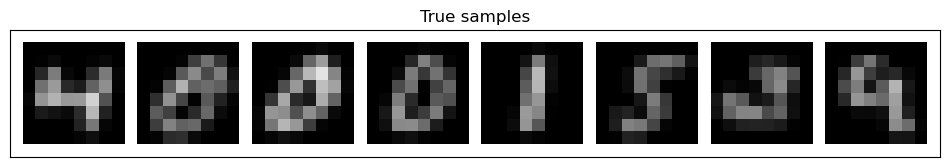

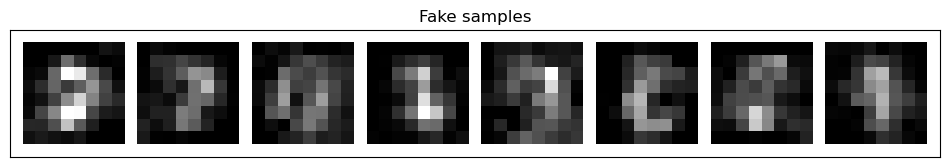

Iteration 4000, energy loss: 23.7962646484375, energy lr 0.000125075


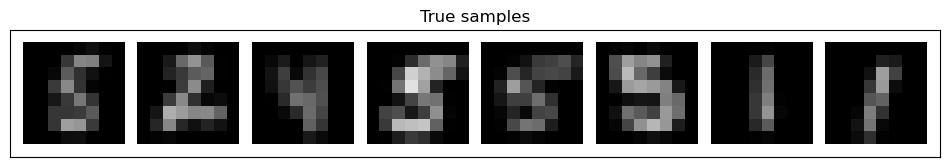

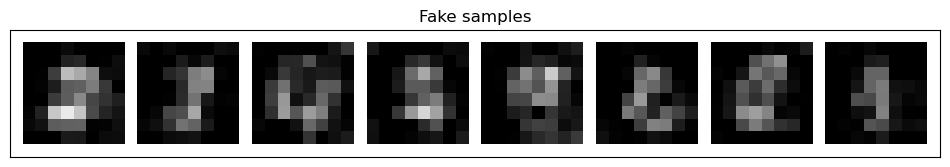

Iteration 5000, energy loss: -0.12149667739868164, energy lr 1e-07


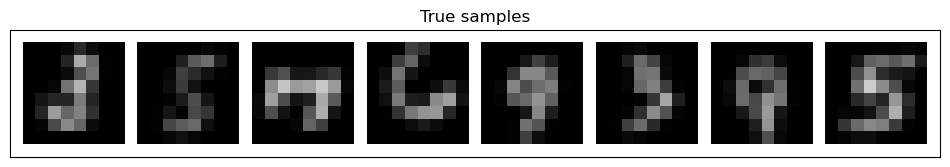

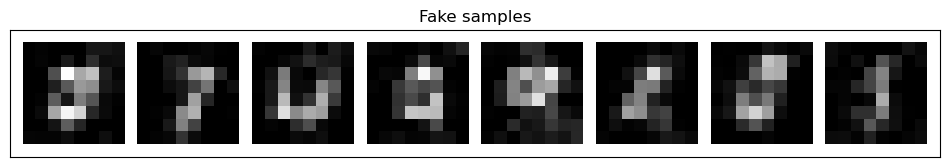

Iteration 6000, energy loss: -20.428054809570312, energy lr 0.00025005


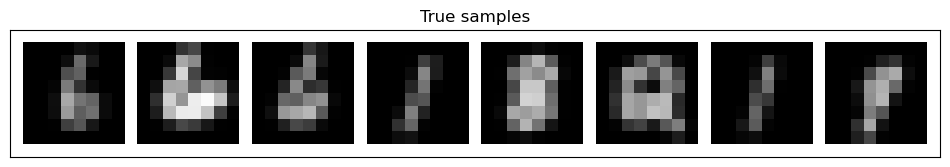

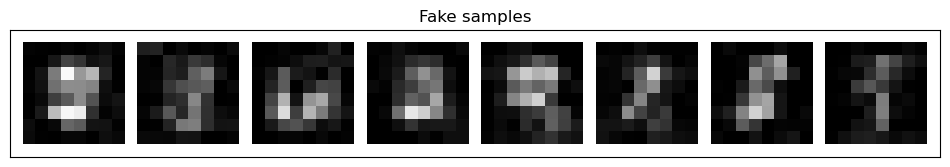

Iteration 7000, energy loss: -22.846694946289062, energy lr 0.00018756250000000007


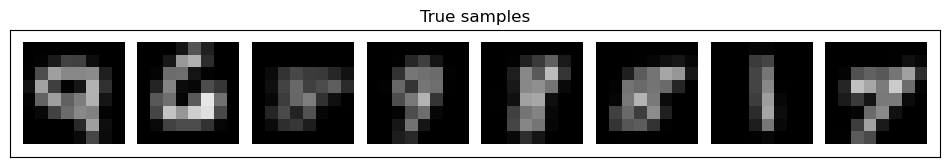

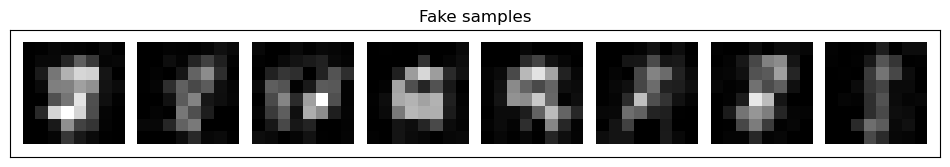

Iteration 8000, energy loss: -17.5167236328125, energy lr 0.000125075


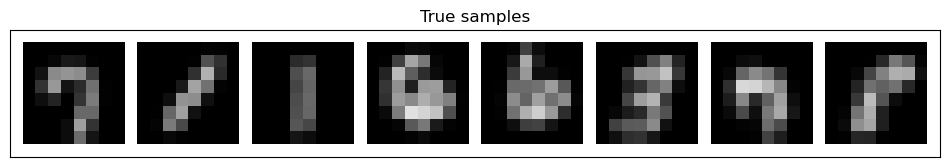

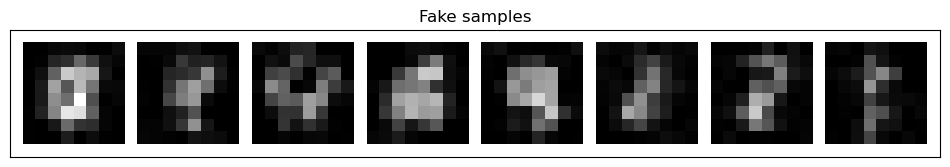

Iteration 9000, energy loss: -6.78900146484375, energy lr 6.258750000000006e-05


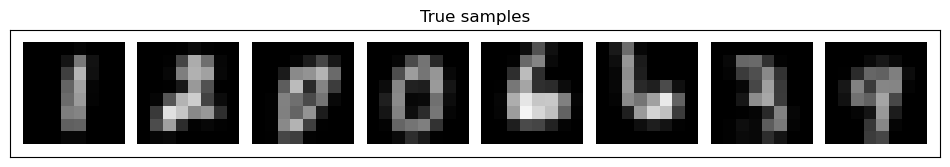

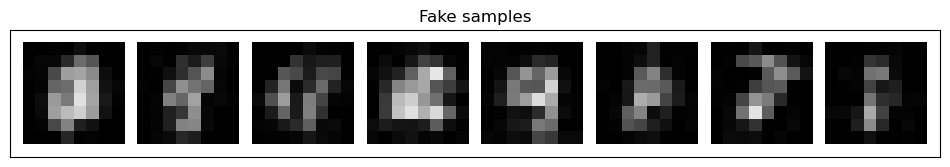

Iteration 10000, energy loss: 3.264495849609375, energy lr 1e-07


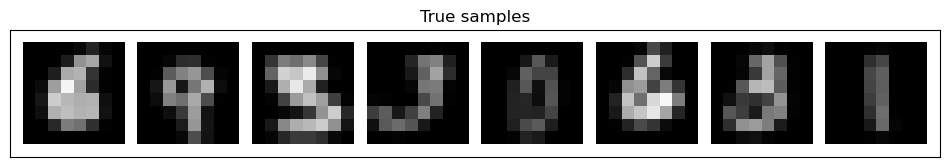

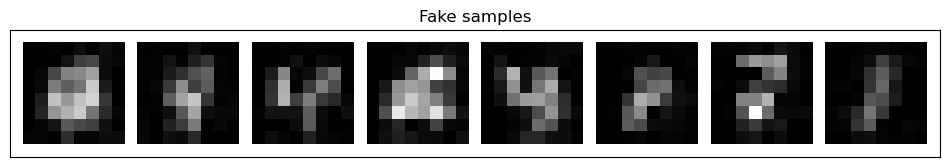

Iteration 11000, energy loss: -31.68206787109375, energy lr 0.000125075


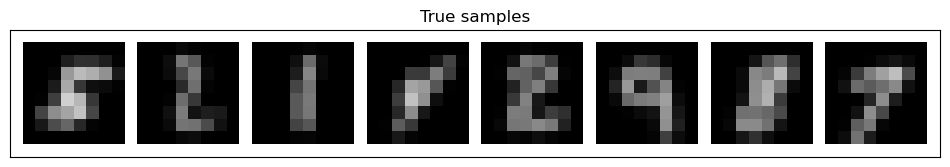

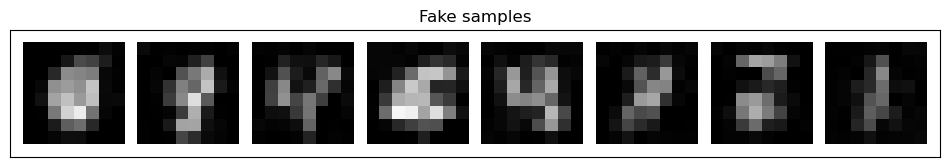

Iteration 12000, energy loss: -16.971649169921875, energy lr 9.383125000000003e-05


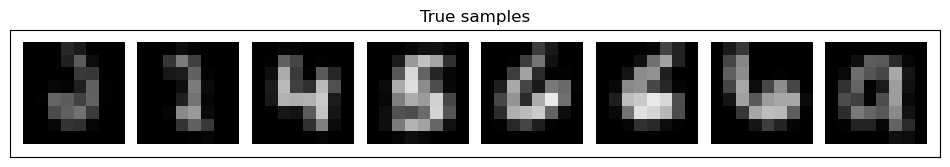

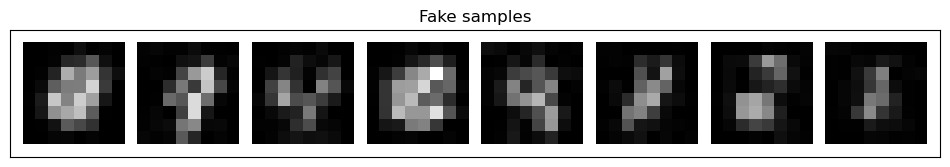

Iteration 13000, energy loss: -4.5242919921875, energy lr 6.25875e-05


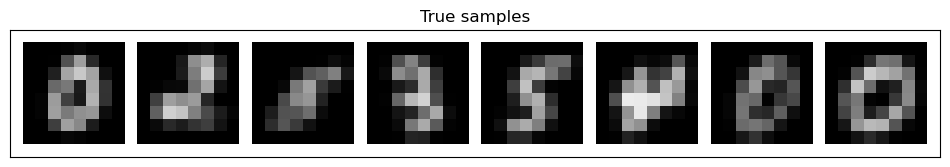

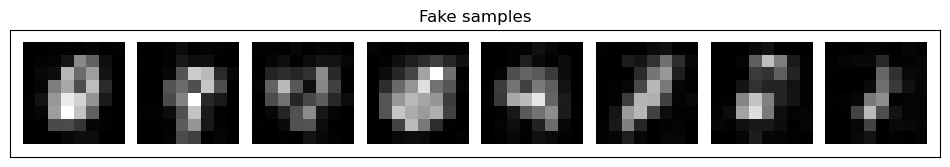

Iteration 14000, energy loss: -6.9034423828125, energy lr 3.1343750000000033e-05


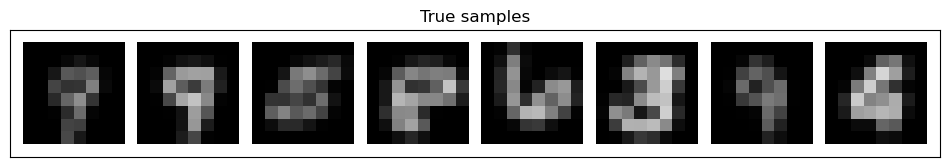

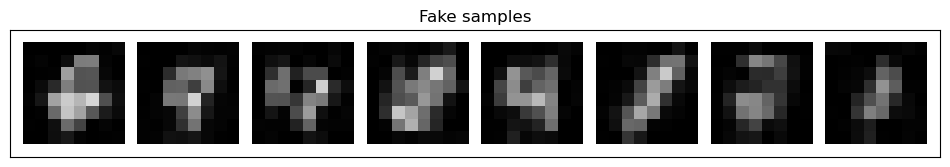

Iteration 15000, energy loss: 7.10760498046875, energy lr 1e-07


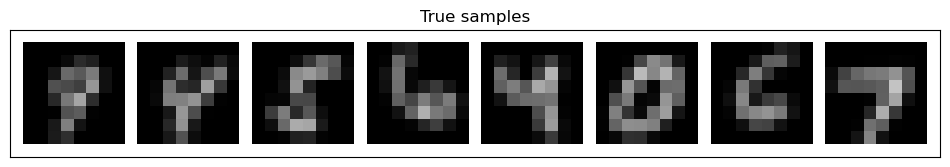

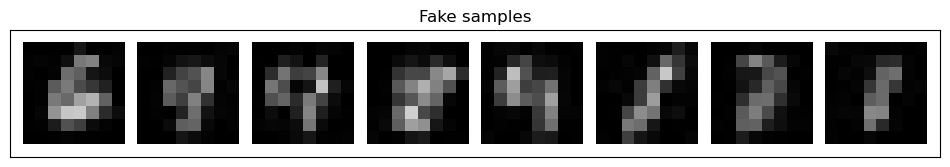

Iteration 16000, energy loss: -13.51605224609375, energy lr 6.25875e-05


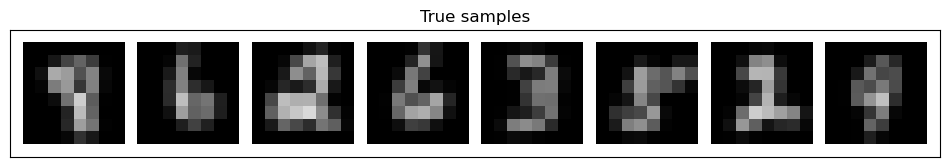

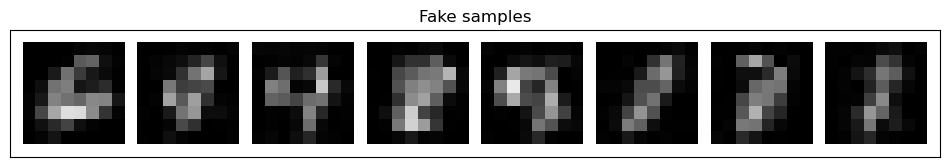

Iteration 17000, energy loss: -13.3446044921875, energy lr 4.696562499999998e-05


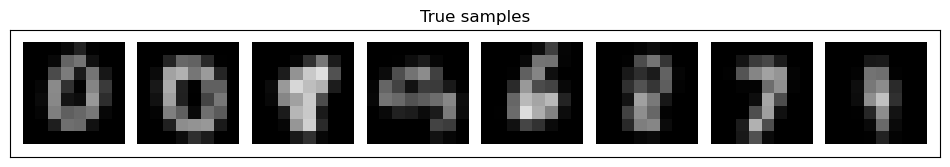

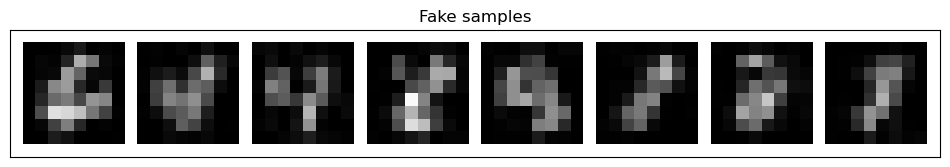

Iteration 18000, energy loss: -8.99658203125, energy lr 3.1343750000000033e-05


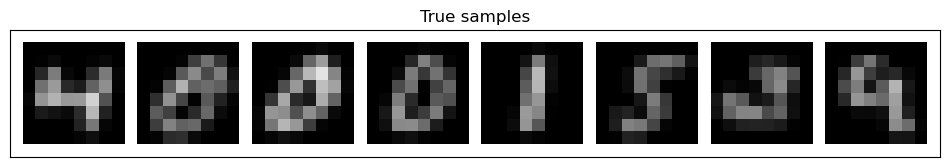

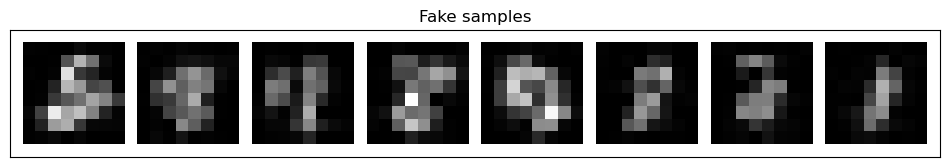

Iteration 19000, energy loss: -10.04974365234375, energy lr 1.5721875000000015e-05


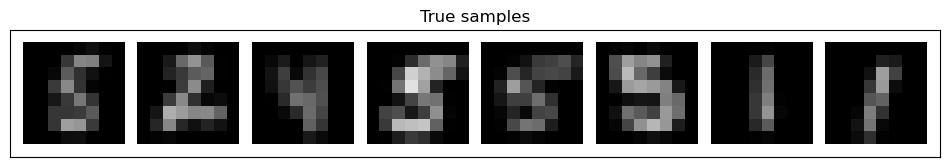

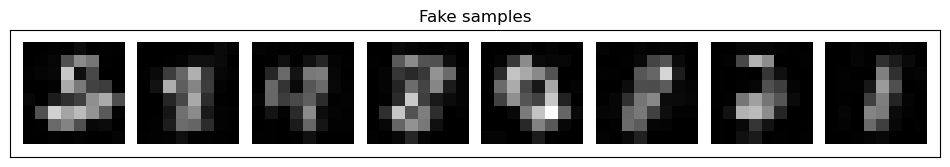

Iteration 20000, energy loss: -0.04705810546875, energy lr 1e-07


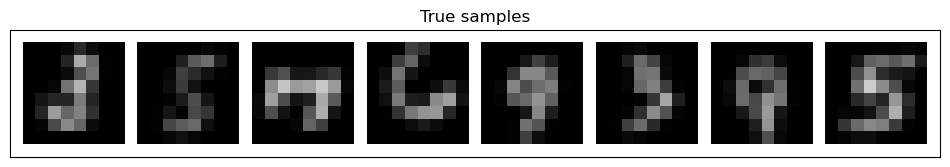

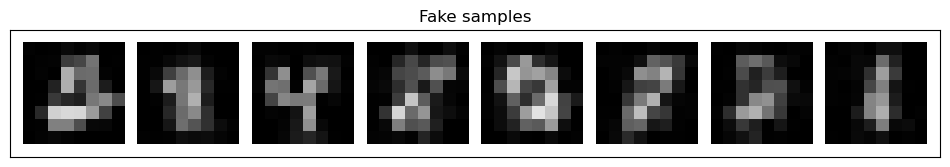

Iteration 21000, energy loss: -26.64349365234375, energy lr 3.134375e-05


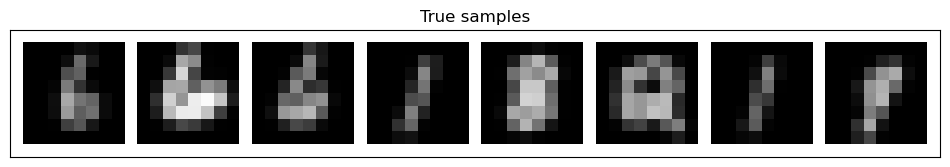

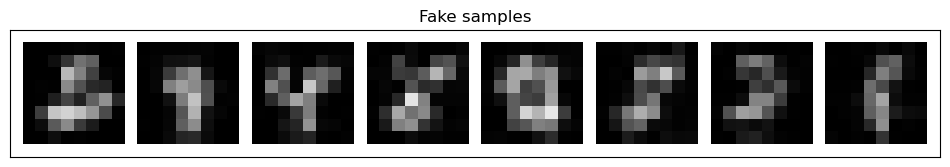

Iteration 22000, energy loss: -15.48809814453125, energy lr 2.3532812499999987e-05


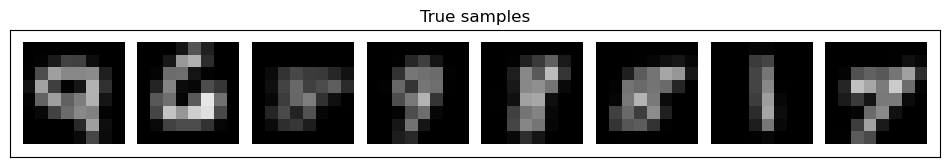

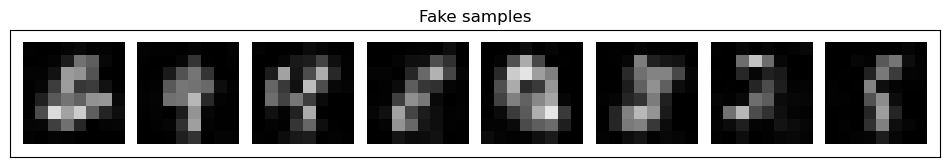

Iteration 23000, energy loss: -21.9140625, energy lr 1.5721875000000015e-05


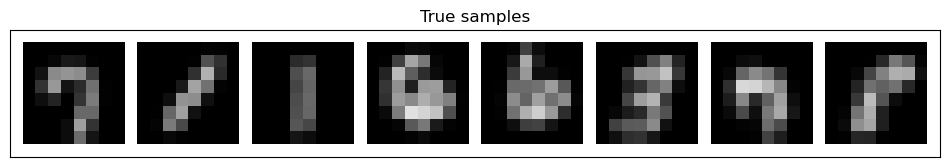

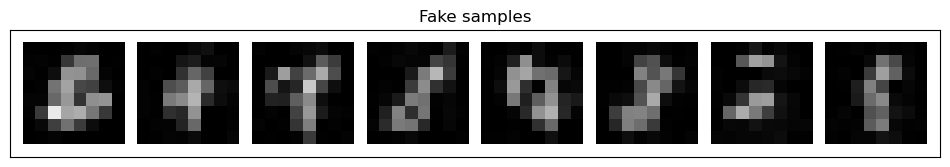

Iteration 24000, energy loss: 1.1231689453125, energy lr 7.910937500000008e-06


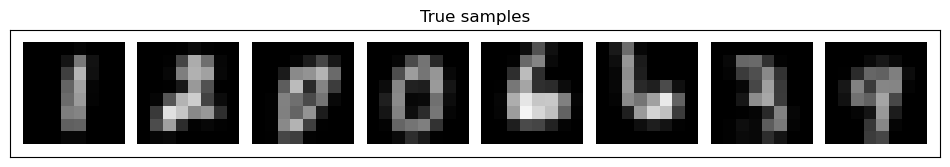

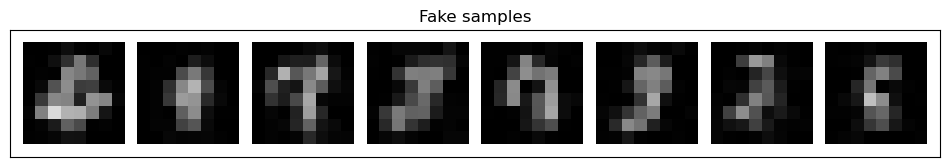

Iteration 25000, energy loss: -1.06207275390625, energy lr 1e-07


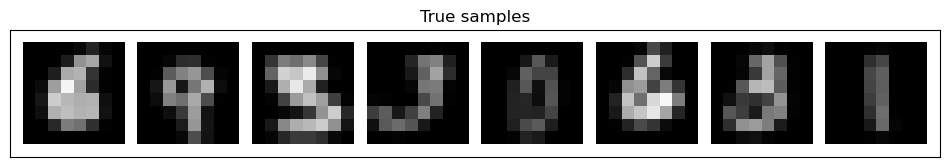

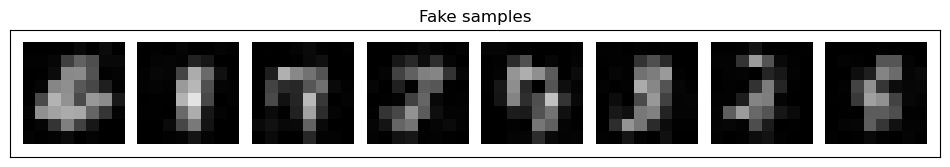

Iteration 26000, energy loss: -11.24993896484375, energy lr 1.5721874999999998e-05


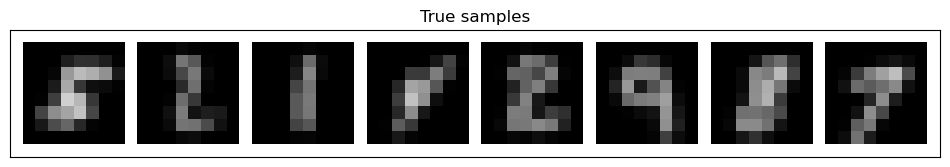

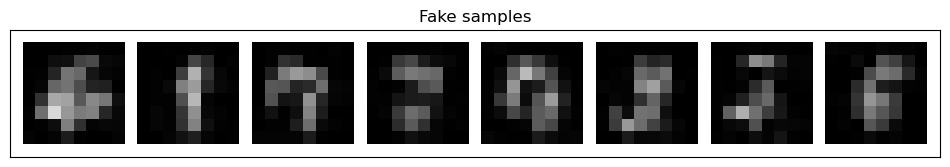

Iteration 27000, energy loss: 7.80419921875, energy lr 1.1816406249999995e-05


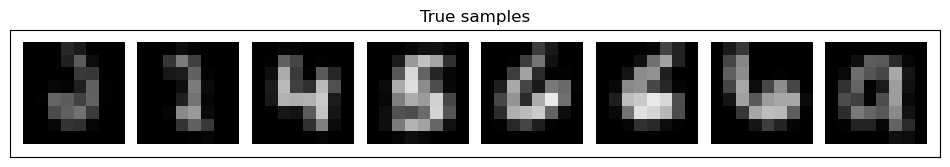

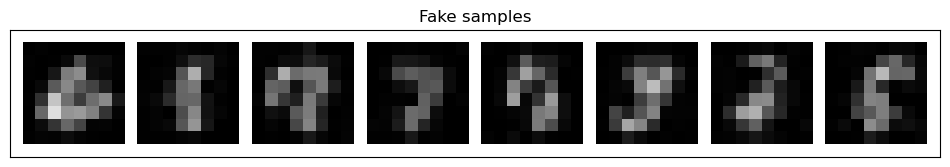

Iteration 28000, energy loss: -5.59222412109375, energy lr 7.910937500000008e-06


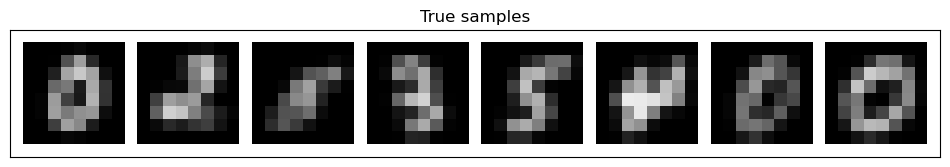

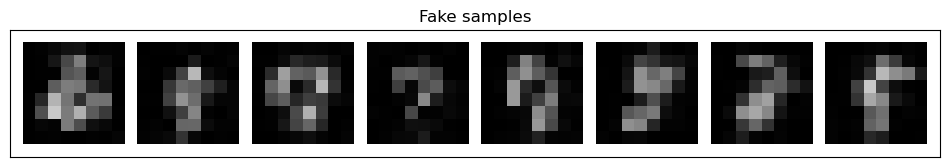

Iteration 29000, energy loss: -6.2054443359375, energy lr 4.005468750000004e-06


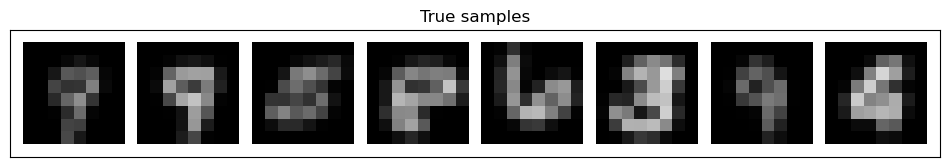

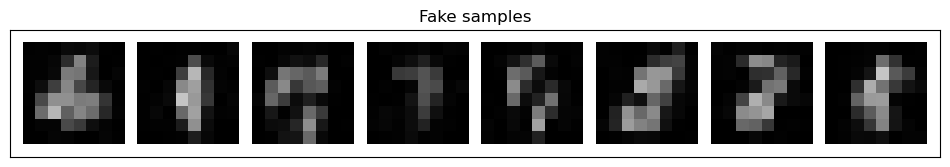

Iteration 30000, energy loss: -3.759033203125, energy lr 1e-07


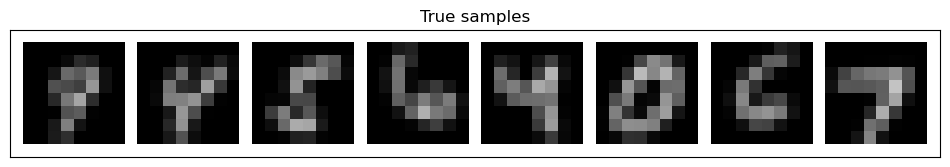

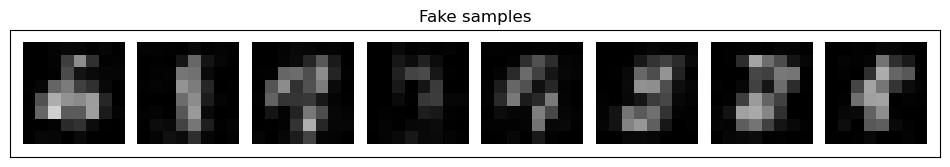

In [21]:
energy = MNISTEnergy()

energy_ema = EMA(energy, decay=0.999, start_update=10_000)
energy_optim = torch.optim.Adam(energy.parameters(), lr=2e-4, weight_decay=0.0)

energy_loss_array = []

n_iter = 30_000
init_step_size = 0.0001
n_langevin_steps = 1

energy_scheduler = torch.optim.lr_scheduler.CyclicLR(
    energy_optim, base_lr=1e-7, max_lr=5e-4, 
    step_size_up=1000, step_size_down=4000,
    mode='triangular2'
)

x_fake = torch.randn(32, 1, 8, 8)
old_noise = torch.randn_like(x_fake)
curr_it = 0

for it in range(1, n_iter + 1):
    curr_it = it
    energy_optim.zero_grad()

    for _ in range(n_langevin_steps):
    # compute gradient
        _x = x_fake.clone().detach().requires_grad_()
        grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
        
        # make a langevin step
        step_size = init_step_size
        new_noise = torch.randn_like(x_fake)
        x_fake = x_fake - 0.5 * step_size * grad 
        x_fake = x_fake + 0.5 * (new_noise + old_noise) * math.sqrt(step_size)
        old_noise = new_noise

    x_true = sampler.sample(32)
    energy_loss = losses.ebm_loss(energy, x_true, x_fake, alpha=0.0, reg_type='l2')
    energy_loss.backward()
    energy_optim.step()

    energy_scheduler.step()
    energy_ema.update()

    energy_loss_array.append(energy_loss.item())

    if it == 1 or it % 1_000 == 0:
        print(f"Iteration {it}, energy loss: {energy_loss.item()}, "
              f"energy lr {energy_optim.param_groups[0]['lr']}")
        plot_image_trajectory(x_true[:8].split(1), title='True samples', apply_rescale=True)
        plot_image_trajectory(x_fake[:8].split(1), title='Fake samples', apply_rescale=True)



1


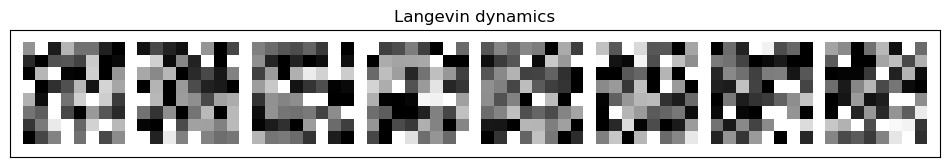

2500


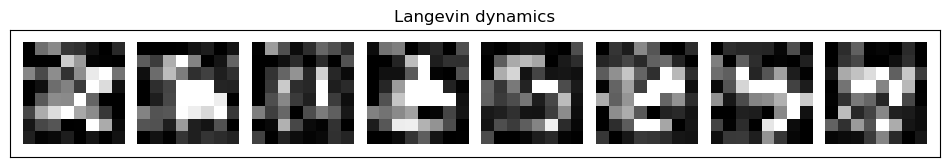

5000


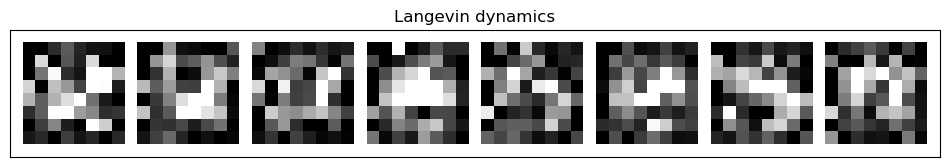

7500


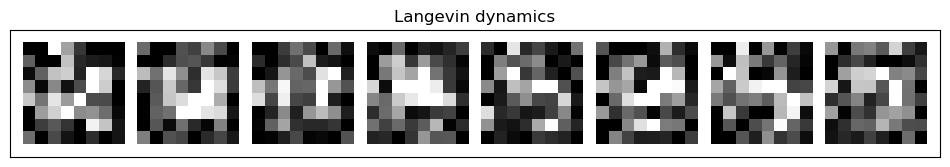

10000


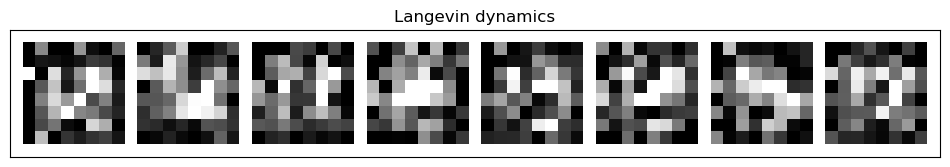

12500


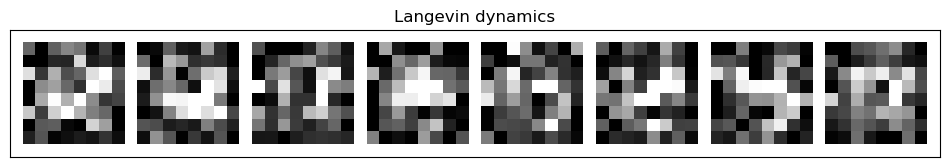

15000


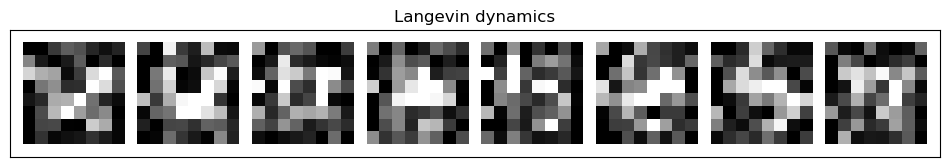

17500


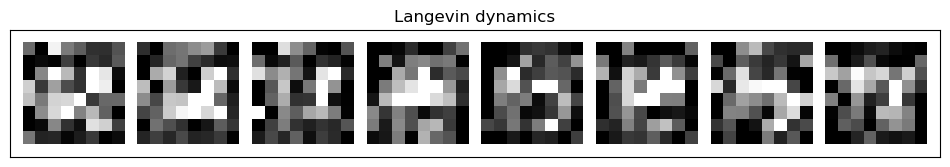

20000


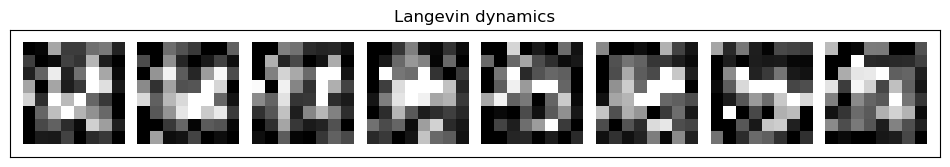

In [68]:
energy_ema.apply_shadow()
x = torch.randn(16, 1, 8, 8) # Ensure tensor is on the correct device

init_step_size = 0.01
n_steps = 20000
rate = 35000

old_noise = torch.randn_like(x)
for it in range(1, n_steps + 1):
    step_size = init_step_size #* (init_step_size ** (i / rate)) 

    # if i == 10_000:
    #     step_size *= 0.1
    
    # compute gradient
    _x = x.clone().detach().requires_grad_()
    grad = torch.autograd.grad(energy(_x).sum(), _x)[0]
    
    # make a langevin step
    temp = max(0.9, 3 * (0.01 ** (it / 15000)))
    new_noise = torch.randn_like(x)
    x = x - 0.5 * step_size * grad / temp
    x = x + 0.5 * (old_noise + new_noise) * math.sqrt(step_size)
    new_noise = old_noise
    
    if it % 2500 == 0 or it == 1:
        print(it)
        plot_image_trajectory(x[:8].split(1), title='Langevin dynamics', apply_rescale=True)

energy_ema.restore()